# Energy landscape of molecule

## Configurations

In [8]:
from sys import stdout

import torch
import random
import mdtraj
import pandas
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
from rdkit.Chem import Draw

from openmm import *
from openmm import *
from openmm.app import *
from openmm.unit import *

from tqdm.auto import tqdm
from matplotlib import animation 
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Import when using Juperter Notebook on browser, not vscode
# import nglview

# Potential energy

In [2]:
# Load molecule file

state = "c5"
file_path = f"../data/alanine/{state}.pdb"
molecule = Chem.MolFromPDBFile(file_path, removeHs=False)

idx1, idx2, idx3, idx4 = 6, 8, 14, 16
idx5, idx6, idx7, idx8 = 4, 6, 8, 14

def set_dihedral(mol, idx1, idx2, idx3, idx4, angle):
    conf = mol.GetConformer()
    rdMolTransforms.SetDihedralDeg(conf, idx1, idx2, idx3, idx4, angle)

In [3]:
def compute_energy(file_path):
	pdb = PDBFile(file_path)
	force_field = ForceField("amber99sbildn.xml", "tip3p.xml")
	platform = Platform.getPlatformByName("OpenCL")
	properties = {'Precision': "mixed"}
	system = force_field.createSystem(
		pdb.topology,
		nonbondedCutoff=3 * nanometer,
		constraints=HBonds
	)
	integrator = LangevinIntegrator(
		300 * kelvin,
		1 / picosecond,
		1 * femtoseconds
	)

	simulation = Simulation(
		pdb.topology,
		system,
		integrator,
		platform,
		properties
	)
	simulation.context.setPositions(pdb.positions)
	simulation.minimizeEnergy()
	simulation.reporters = [
		StateDataReporter(
			stdout,
			reportInterval=1,
			step=True,
			time=True,
			potentialEnergy=True,
			temperature=True,
			progress=True,
			elapsedTime=True,
			totalSteps=1
	)]

	energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
	return energy._value

In [32]:
# Compute energy for each psi and phi angles
potential_energy_list = []

for psi in tqdm(range(-180, 180, 90), desc="psi"):
	for phi in tqdm(range(-180, 180, 90), leave=False, desc="phi"):
		# print(f"Computing energy for psi={psi} and phi={phi}")
		set_dihedral(molecule, idx1, idx2, idx3, idx4, psi)
		set_dihedral(molecule, idx5, idx6, idx7, idx8, phi)

		new_file_name = f"../data/potential/psi{psi}-phi{phi}.pdb"
		if not os.path.exists(new_file_name):
			Chem.MolToPDBFile(molecule, new_file_name)
			# print(f"File {new_file_name} created")
		else:
			print(f"File {new_file_name} already exists")
		potential_energy_list.append([psi, phi, compute_energy(new_file_name)])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
pd.DataFrame(potential_energy_list).to_csv(
    f"../data/ad-pot-ex.dat",
    index=False,
    header=["Psi", "Phi", "Energy"]
)

In [6]:
file_path = "../data/ad-pot.dat"
	
with open(file_path) as f:
	lines = f.readlines()

In [17]:
dims = [90, 90]
locations = torch.zeros((int(dims[0]), int(dims[1]), 2))
data = torch.zeros((int(dims[0]), int(dims[1])))

i = 0
for line in lines[1:]:
	splits = line[0:-1].split(",")
	x = float(splits[0])
	y = float(splits[1])
	val = float(splits[-1])

	locations[i // 90, i % 90, :] = torch.tensor(np.array([x, y]))
	data[i // 90, i % 90] = (val)  # / 503.)
	i = i + 1

torch.Size([90, 90])


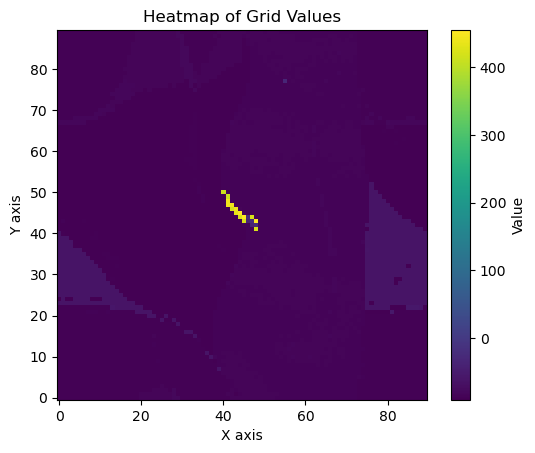

In [19]:
print(data.shape)
data_np = data.numpy()

plt.imshow(data_np, cmap='viridis', origin='lower')
plt.colorbar(label='Value')  # Add a color bar to indicate value scale
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Heatmap of Grid Values')
plt.show()